In [50]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# ResNet-18 CNN Architecture

In [13]:
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [9]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the appropriate device
model = ResNet18(num_classes=10).to(device)

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.1

# Prepare the CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:  # Print every 100 mini-batches
            print(f'Batch {batch_idx + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Train the model
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train(model, train_loader, criterion, optimizer, device)
    accuracy = evaluate(model, test_loader, device)
    scheduler.step()  # Adjust the learning rate

print("Training complete.")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Batch 100, Loss: 2.6186
Batch 200, Loss: 1.9886
Batch 300, Loss: 1.7956
Test Accuracy: 41.94%
Epoch 2/10
Batch 100, Loss: 1.5333
Batch 200, Loss: 1.4684
Batch 300, Loss: 1.4212
Test Accuracy: 52.85%
Epoch 3/10
Batch 100, Loss: 1.2750
Batch 200, Loss: 1.2665
Batch 300, Loss: 1.1879
Test Accuracy: 61.53%
Epoch 4/10
Batch 100, Loss: 1.0717
Batch 200, Loss: 1.0530
Batch 300, Loss: 1.0178
Test Accuracy: 62.57%
Epoch 5/10
Batch 100, Loss: 0.9737
Batch 200, Loss: 0.9364
Batch 300, Loss: 0.9008
Test Accuracy: 65.12%
Epoch 6/10
Batch 100, Loss: 0.8723
Batch 200, Loss: 0.8372
Batch 300, Loss: 0.8248
Test Accuracy: 71.32%
Epoch 7/10
Batch 100, Loss: 0.7662
Batch 200, Loss: 0.7493
Batch 300, Loss: 0.7518
Test Accuracy: 71.08%
Epoch 8/10
Batch 100, Loss: 0.7020
Batch 200, Loss: 0.6987
Batch 300, Loss: 0.6899
Test Accuracy: 73.13%
Epoch 9/10
Batch 100, Loss: 0.6364
Batch 200, Loss: 0.6715
Batch 300, Loss: 0.6520
T

## Predicting the Result

In [27]:
class_names = [
    'airplane', 'automobile', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse',
    'ship', 'truck'
]

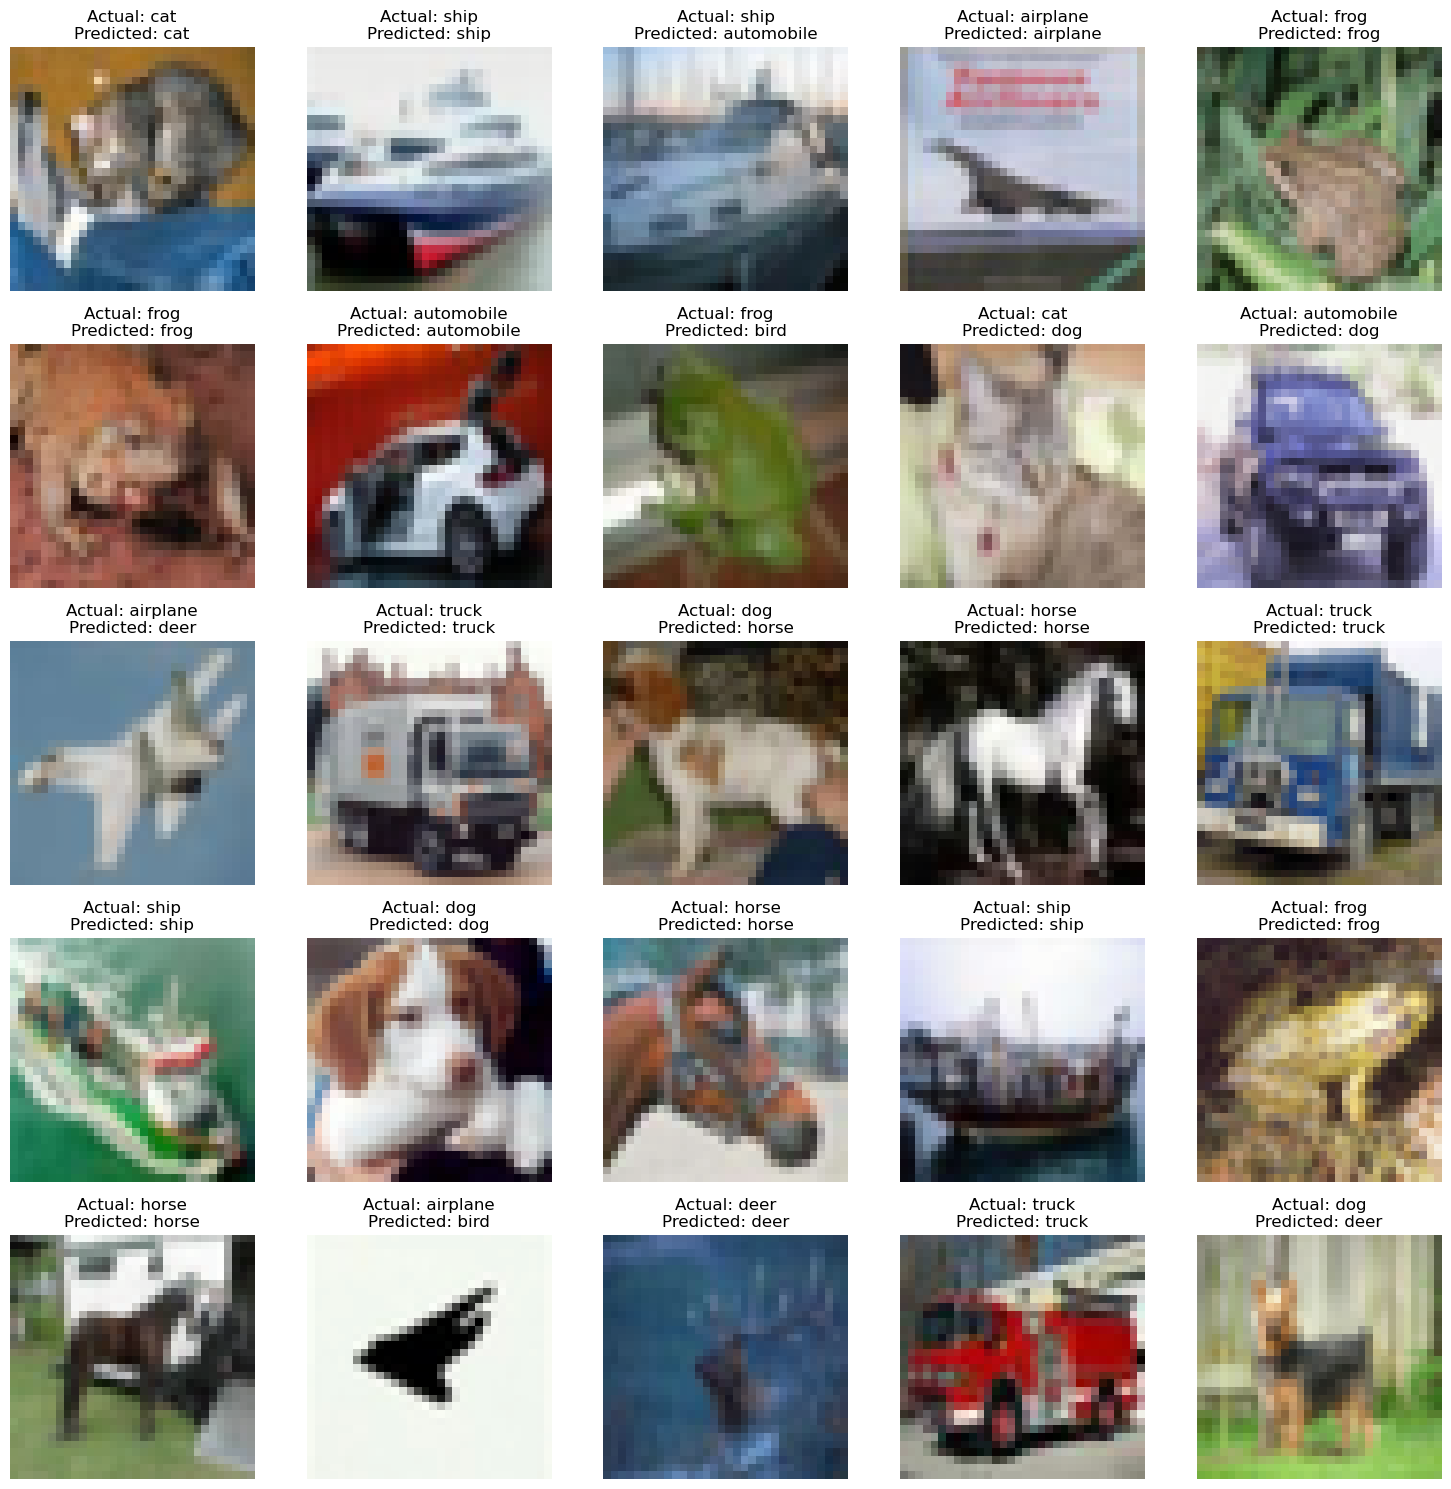

In [28]:
def plot_actual_vs_predicted(model, data_loader, device, num_images=10):
    model.eval()
    images_displayed = 0
    
    plt.figure(figsize=(15, 15))
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Convert tensors to numpy arrays for visualization
            inputs = inputs.cpu().numpy()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            for i in range(inputs.shape[0]):
                if images_displayed >= num_images:
                    break
                
                # Un-normalize and transpose the image to (H, W, C)
                img = inputs[i]
                img = img * np.array([0.2023, 0.1994, 0.2010]).reshape((3, 1, 1))
                img = img + np.array([0.4914, 0.4822, 0.4465]).reshape((3, 1, 1))
                img = np.clip(img, 0, 1)  # Clip to valid range
                img = np.transpose(img, (1, 2, 0))
                
                # Plot the image with actual and predicted labels
                plt.subplot(5, 5, images_displayed + 1)
                plt.imshow(img)
                actual_label = class_names[labels[i]]
                predicted_label = class_names[predicted[i]]
                plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
                plt.axis('off')
                
                images_displayed += 1
            
            if images_displayed >= num_images:
                break
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_actual_vs_predicted(model, test_loader, device, num_images=25)

# VGG-16 CNN Architecture

In [69]:
from torchvision import models

# Load a pre-trained VGG-16 model and adapt it for CIFAR-10
vgg16 = models.vgg16(pretrained=False)
vgg16.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Adjust for CIFAR-10 input size
vgg16.avgpool = nn.Identity()  # Remove pooling to fit 32x32 input

# Modify the classifier for CIFAR-10
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 1 * 1, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 10)  # 10 classes for CIFAR-10
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

C:\Study\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Study\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [70]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [74]:
num_epochs = 10

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100.*correct/total:.2f}%')

    scheduler.step()
    
vgg16.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = vgg16(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')

Epoch 1/10, Loss: 2.304085974803056, Accuracy: 10.33%
Epoch 2/10, Loss: 2.3042045596920318, Accuracy: 9.91%
Epoch 3/10, Loss: 2.3042407249245804, Accuracy: 9.94%
Epoch 4/10, Loss: 2.3044666481749787, Accuracy: 10.02%
Epoch 5/10, Loss: 2.304266347299756, Accuracy: 9.92%
Epoch 6/10, Loss: 2.3044159875806334, Accuracy: 9.91%
Epoch 7/10, Loss: 2.304273628517795, Accuracy: 10.06%
Epoch 8/10, Loss: 2.3044233291655245, Accuracy: 9.91%
Epoch 9/10, Loss: 2.304325384252212, Accuracy: 10.06%
Epoch 10/10, Loss: 2.3045699980557726, Accuracy: 9.73%
Test Accuracy: 10.00%


# ResNet-50 Architecture

In [75]:
from torchvision import models

resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [76]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}, Accuracy: {100.*correct/total:.2f}%')

    scheduler.step()
    
resnet50.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = resnet50(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')

Epoch 1/10, Loss: 2.255, Accuracy: 15.03%
Epoch 2/10, Loss: 1.882, Accuracy: 28.52%
Epoch 3/10, Loss: 1.721, Accuracy: 35.34%
Epoch 4/10, Loss: 1.624, Accuracy: 40.01%
